# Notebook to explore the DCF data

## Importing required modules

In [17]:
import h5py
import ipywidgets as widgets
import matplotlib.pyplot as plt
import dcf_tool

## Defining functions which allow user to see all datasets

In [18]:
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])

In [19]:
h5dump('DCFfile.h5', 'ICRP116')

	 - eyes : <HDF5 group "/ICRP116/eyes" (3 members)>
		 - electrons : <HDF5 group "/ICRP116/eyes/electrons" (3 members)>
			 - AP : <HDF5 dataset "AP": shape (42, 2), type "<f8">
			 - ISO : <HDF5 dataset "ISO": shape (42, 2), type "<f8">
			 - PA : <HDF5 dataset "PA": shape (42, 2), type "<f8">
		 - neutrons : <HDF5 group "/ICRP116/eyes/neutrons" (5 members)>
			 - AP : <HDF5 dataset "AP": shape (68, 2), type "<f8">
			 - ISO : <HDF5 dataset "ISO": shape (68, 2), type "<f8">
			 - LAT : <HDF5 dataset "LAT": shape (68, 2), type "<f8">
			 - PA : <HDF5 dataset "PA": shape (68, 2), type "<f8">
			 - ROT : <HDF5 dataset "ROT": shape (68, 2), type "<f8">
		 - photons : <HDF5 group "/ICRP116/eyes/photons" (5 members)>
			 - AP : <HDF5 dataset "AP": shape (50, 2), type "<f8">
			 - ISO : <HDF5 dataset "ISO": shape (50, 2), type "<f8">
			 - LAT : <HDF5 dataset "LAT": shape (50, 2), type "<f8">
			 - PA : <HDF5 dataset "PA": shape (50, 2), type "<f8">
			 - ROT : <HDF5 dataset "ROT": shape (50

In [25]:
file = h5py.File('DCFfile.h5', 'r')

# Over to you!

First, select the unit you would like your DCF data to be inputted in. Only select 'pGy cm2' if and only if your selected organ is not 'full_body'.

In [21]:
output_dcf_units = widgets.Dropdown(options=['microSv/h per particle/cm2/s', 'rem/h per particle/cm2/s', 'pSv cm2', 'pGy cm2'], description = 'Output DCF units: ', disabled = False)
display(output_dcf_units)

Dropdown(description='Output DCF units: ', options=('microSv/h per particle/cm2/s', 'rem/h per particle/cm2/s'…

Here you can input as many datasets as you like and plot them to compare. The datasets should be specified using the check function with the form (filename, group, organ, particle, orientation, output_dcf_unit).
The available groups are ESS, NCRP38, ICRP116. To see the organs, datasets and orientations in each group, use the dump function above.
Follow the plotting examples below to plot your data.

In [26]:
dcf1 = dcf_tool.check(file, 'ICRP116', 'full_body', 'neutrons', 'PA', output_dcf_units.value)
dcf2 = dcf_tool.check(file, 'ICRP116', 'full_body', 'neutrons', 'AP', output_dcf_units.value)
dcf3 = dcf_tool.check(file, 'ICRP116', 'full_body', 'neutrons', 'LLAT', output_dcf_units.value)

Plot! The first dataset is plotted slightly different due to the nature of pandas - see below.

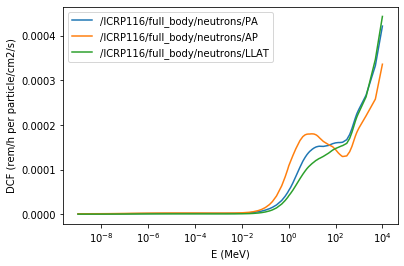

In [27]:
ax = dcf1.data.plot(kind='line', x=dcf1.data.columns[0], y=dcf1.data.columns[1], xlabel=('E ({})'.format(dcf1.e_units)), ylabel=('DCF ({})'.format(dcf1.dcf_units)), legend=False, logx=True)
dcf2.data.plot(kind='line', x=dcf2.data.columns[0], y=dcf2.data.columns[1], xlabel=('E ({})'.format(dcf2.e_units)), ylabel=('DCF ({})'.format(dcf2.dcf_units)), legend=False, logx=True, ax=ax)
dcf3.data.plot(kind='line', x=dcf3.data.columns[0], y=dcf3.data.columns[1], xlabel=('E ({})'.format(dcf3.e_units)), ylabel=('DCF ({})'.format(dcf3.dcf_units)), legend=False, logx=True, ax=ax)
plt.legend([dcf1.path, dcf2.path, dcf3.path])

## Select and plot your data here!

Make sure to close the hdf5 file when you're done!

In [24]:
file.close()